# 1. Загрузка данных

In [248]:
import pandas as pd
import numpy as np

In [249]:
df_glass = pd.read_csv('glass.csv')
df_glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


# 2. Первичный анализ данных

In [250]:
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Пропуски в датасете отсутствуют.

In [251]:
df_glass.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Статистика выше вроде как уже указаывает на наличие выбросов (очень заметно для RI, Al, K, Ba, Fe и Type).

# 3. Разделение данных на train и test

In [252]:
from sklearn.model_selection import train_test_split

In [253]:
X = df_glass.drop(['Type'], axis=1)
X.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [254]:
y = df_glass['Type']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Type, dtype: int64

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Обучение RandomForestClassifier

In [256]:
from sklearn.ensemble import RandomForestClassifier

In [257]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 5. Оценка точности

In [258]:
print(f'train: {model.score(X_train, y_train)}\ntest: {model.score(X_test, y_test)}')

train: 1.0
test: 0.8372093023255814


Модель переобучилась, но, при этом, значение score для тестовых данных достаточно высокое.

# 6. Обработка выбросов

## 6.1. Визуализация распределений значений признаков

In [259]:
import seaborn as sns
from matplotlib import pyplot as plt

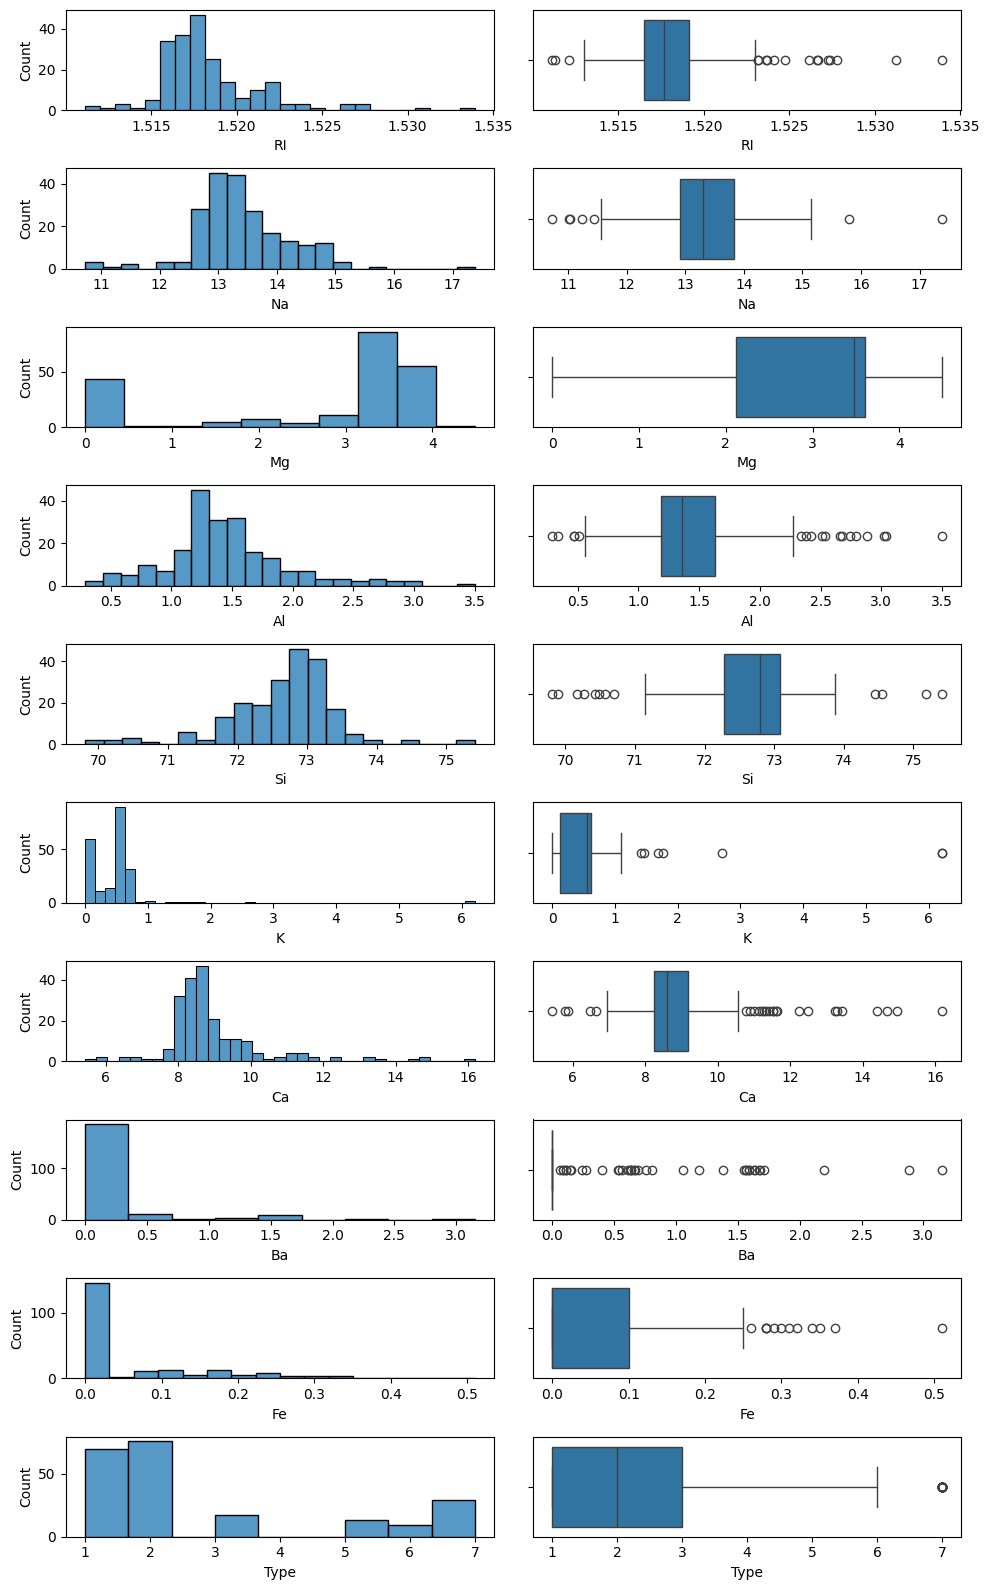

In [260]:
fig, ax = plt.subplots(10, 2, figsize=(10, 16))

for i, col in enumerate(df_glass.columns):
  sns.histplot(df_glass[col], ax=ax[i][0])
  sns.boxplot(df_glass[col], ax=ax[i][1], orient='h')
  plt.tight_layout()

Визуализация показала наличие выбросов во всех признаках кроме Mg.

Распределения для признаков RI, Na, Al, Ca близки к нормальному. Боксплоты примерно симметричны, а части гистограмм без выбросов, в целом, напоминают по форме колокол.

## 6.2. Исследование признаков на выбросы

In [261]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [262]:
df_clear = df_glass.copy()

for i, col in enumerate(df_glass.columns):
  q1, q3 = np.percentile(df_glass[col], [25, 75])
  iqr = q3 - q1
  l = q1 - 1.5 * iqr
  r = q3 + 1.5 * iqr

  df_clear = df_clear.loc[df_glass[col].between(l, r)]

df_outlier = pd.concat([df_glass, df_clear]).drop_duplicates(keep=False)

In [263]:
print(f'Строк с выбросами: {len(df_outlier)} ({round(100 * len(df_outlier) / len(df_glass), 1)}% всех данных).')

Строк с выбросами: 76 (35.5% всех данных).


### 6.2.1. OneClassSVM

In [264]:
scaler = StandardScaler()
X_standart = scaler.fit_transform(X)

In [265]:
pred = {}
real = [-1 if x else 1 for x in X.index.isin(df_outlier.index)]

In [266]:
def get_outlier(model, X, df_outlier, real):
  model.fit(X)
  pred = model.predict(X)

  print(f'Всего выбросов: {np.unique(pred, return_counts=True)[1][0]}')
  print(f'{np.unique((real + pred) == -2, return_counts=True)[1][1]} из которых в действительности находятся за пределами минимума/максимума')

  return pred

In [267]:
model = OneClassSVM(nu=0.1)
model_name = model.__class__.__name__
pred[model_name] = get_outlier(model, X, df_outlier, real)

Всего выбросов: 23
20 из которых в действительности находятся за пределами минимума/максимума


In [268]:
model_name = model.__class__.__name__ + '_standart'
pred[model_name] = get_outlier(OneClassSVM(nu=0.1), X_standart, df_outlier, real)

Всего выбросов: 18
15 из которых в действительности находятся за пределами минимума/максимума


OneClassSVM предсказала наличие 18 выбросов для стандартизированных данных и 23 для нестандартизированных.

### 6.2.2. IsolationForest

In [269]:
model = IsolationForest(random_state=42)
model_name = model.__class__.__name__
pred[model_name] = get_outlier(model, X, df_outlier, real)

Всего выбросов: 21
21 из которых в действительности находятся за пределами минимума/максимума


В случае IsolationForest все найдены выбросы совпали с реальными (за пределами экстримальных значений), при этом их уже не 76, а 21.

### 6.2.3. EllipticEnvelope

In [270]:
model = EllipticEnvelope(random_state=42)
model_name = model.__class__.__name__
pred[model_name] = get_outlier(model, X, df_outlier, real)

Всего выбросов: 22
22 из которых в действительности находятся за пределами минимума/максимума


Всего 22 выброса, все совпали с реальными.

### 6.2.4. LocalOutlierFactor

In [271]:
model = LocalOutlierFactor(n_neighbors=10, novelty=True)
model_name = model.__class__.__name__
pred[model_name] = get_outlier(model, X.values, df_outlier, real)

Всего выбросов: 27
16 из которых в действительности находятся за пределами минимума/максимума


LocalOutlierFactor на первый взгляд справился плохо - не все обнаруженные им выбросы находятся за пределами минимума/максимума.

При этом изменение параметра n_neighbors не особо влияет на количество выбросов, несовпадающих с реальными.

### 6.2.5. DBSCAN

In [272]:
def get_outlier_dbscan(model, X, df_outlier, real):
  model.fit(X)
  pred = model.labels_

  print(f'Всего выбросов: {np.unique(pred, return_counts=True)[1][0]}')
  print(f'{np.unique((real + pred) == -2, return_counts=True)[1][1]} из которых в действительности находятся за пределами минимума/максимума')

  return pred

In [273]:
model = DBSCAN(eps=2, min_samples=10)
model_name = model.__class__.__name__
pred[model_name] = get_outlier_dbscan(model, X, df_outlier, real)

Всего выбросов: 19
19 из которых в действительности находятся за пределами минимума/максимума


In [274]:
model = DBSCAN(eps=3, min_samples=10)
model_name = model.__class__.__name__ + '_standart'
pred[model_name] = get_outlier_dbscan(model, X_standart, df_outlier, real)

Всего выбросов: 15
15 из которых в действительности находятся за пределами минимума/максимума


## 6.3. Обучение моделей после удаления выбросов

Обучение модели послу удаления всех выбросов (согласно границам экстримальных значений). Это 35.5% данных.

In [275]:
X = df_clear.drop(['Type'], axis=1)
y = df_clear['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print(f'for train = {model.score(X_train, y_train)}\nfor test = {model.score(X_test, y_test)}')

for train = 1.0
for test = 0.75


**df_fix** - датафрейм с указанием признака выброса для каждой ранее обученных в п.п. 6.2 моделей.

In [276]:
for m_name, p_values in pred.items():
  df_fix = df_glass.copy()
  df_fix[m_name] = p_values
  df_fix = df_fix.loc[df_fix[m_name] != -1]

  X = df_fix.drop(['Type', m_name], axis=1)
  y = df_fix['Type']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = RandomForestClassifier(random_state=42)
  model.fit(X_train, y_train)

  print(f'{m_name}: ')
  print(f'for train = {model.score(X_train, y_train)}\nfor test = {model.score(X_test, y_test)}\n')

OneClassSVM: 
for train = 1.0
for test = 0.6923076923076923

OneClassSVM_standart: 
for train = 1.0
for test = 0.775

IsolationForest: 
for train = 1.0
for test = 0.6666666666666666

EllipticEnvelope: 
for train = 1.0
for test = 0.7692307692307693

LocalOutlierFactor: 
for train = 1.0
for test = 0.7631578947368421

DBSCAN: 
for train = 1.0
for test = 0.7692307692307693

DBSCAN_standart: 
for train = 1.0
for test = 0.875



Лучше всех с поиском выбросов справился алгоритм DBSCAN для стандартизированных данных - скор для тестовых данных 0.875 (без удаления выбросов было 0.837). Но, в целом, результат несильно отличается.

Как мне кажется, выбросы могут влиять на точность предсказаний для тестовых данных, т.к. модель переобучается и по факту пытается запомнить предсказания тренировочных данных.

В случае большого количества данных за пределами экстремальных значений  лучше использовать алгоритмы для поиска выбросов, например, тот же DBSCAN с корректным подбором eps и min_samples.